In [1]:
import numpy as np
import skimage.io as io
import skimage.color as color
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.measure import find_contours, regionprops
import skimage.morphology as morphology

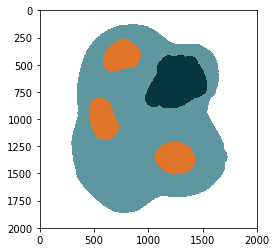

In [2]:
im = io.imread('./blob1.jpg')
plt.imshow(im)
plt.show()

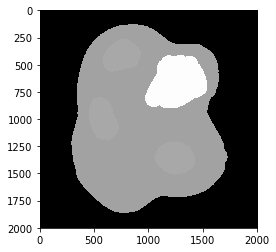

In [3]:
#Check gray values: are they distinct enough?
imbw = color.rgb2gray(im)
plt.imshow(imbw,cmap=plt.get_cmap('Greys'))
plt.show()
#Not quite enough to be super robust; color is a better choice

### Get the edges of all the shapes
Approach: segment the objects by K-means on RGB values, then use regionprops to get the
    individual objects in each cluster and get their contour

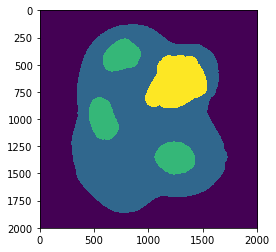

In [4]:
#Segmentation by KMeans clustering on RGB values
n_clusters = 4
pixel_list = np.reshape(im,newshape=(-1,3))
kmeans_result = KMeans(n_clusters=n_clusters,random_state=0).fit(pixel_list)
label_image = np.reshape(kmeans_result.labels_, newshape=im.shape[:-1])
plt.imshow(label_image)
plt.show()

In [5]:
def get_blob_info(cluster_index, region, full_image_shape):
    '''Create a dict for a blob that contains its contour and region props 
    (and the K-means label it corresponds to)'''
    
    this_blob = dict()
    this_blob['cluster_index'] = cluster_index
    this_blob['regionprops'] = region
    #Isolate only this particular blob in the image
    im_only_this_blob = np.zeros(full_image_shape, dtype=bool)
    im_only_this_blob[region['coords'][:,0], region['coords'][:,1]] = True
    this_blob['contour'] = find_contours(im_only_this_blob,0.5)[0]
    
    return this_blob

In [6]:
#Run through each label and get information on each distinct blob from each label
blob_list = []
full_image_shape = label_image.shape
for k in range(1,n_clusters): #omit first cluster, which is background
    segmented_by_label = label_image == k
    labeled_blobs, n_blobs = morphology.label(segmented_by_label, return_num=True)
    rp = regionprops(labeled_blobs)
    for region in rp:
        this_blob = get_blob_info(k, region, full_image_shape)
        blob_list.append(this_blob)

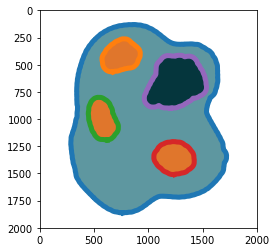

In [7]:
plt.imshow(im)
for blob in blob_list:
    plt.plot(blob['contour'][:,1],blob['contour'][:,0],linewidth=5)
plt.show()

### Find distance between centroid and contour
The regionprops command provides the centroid of the object, so it's just a matter of taking the distance between the contour coordinates and the regionprops centroid

In [8]:
outer_contour = blob_list[0]['contour']
for k,blob in enumerate(blob_list[1:]):
    centroid = blob['regionprops']['centroid']
    distance = np.sqrt(np.sum((outer_contour - centroid)**2,axis=1))
    print('sub-blob {} minimum distance: {}'.format(k + 1, np.min(distance)))

sub-blob 1 minimum distance: 267.92385135936644
sub-blob 2 minimum distance: 233.7151844543495
sub-blob 3 minimum distance: 356.7334978630838
sub-blob 4 minimum distance: 344.0195262333451


### Smoothing the bumpy object
I rather liked the discussion here: https://stackoverflow.com/questions/51259361/smooth-a-bumpy-circle/51267877 .
I think the most conceptually elegant is the Fourier domain solution, but the easiest to code is the averaging one.

Before this I tried fitting a spline (with `scipy.interpolate.UnivariateSpline`) to the x and y coordinates separately, but it breaks down at the endpoint. Something that explicitly uses the circular boundary conditions is needed.

In [9]:
def smooth_contour_moving_average(contour,window_size=None):
    '''Given a contour, calculate a weighted average around the '''
    did_transpose = 0
    if not 2 in contour.shape:
        raise ValueError()
    elif contour.shape[1] == 2:
        pass
    else:
        contour = np.transpose(contour)
        did_transpose = 1
    
    if window_size == None:
        window_size = round(len(contour)*0.02) + 1
    
    avg_contour = np.copy(contour)
    for k in range(1,window_size+1):
        avg_contour = avg_contour + np.roll(contour,k,axis=0) + np.roll(contour,-k,axis=0)
    avg_contour /= (2*window_size+1)
    
    if did_transpose:
        avg_contour = np.transpose(avg_contour)
    
    return avg_contour
    

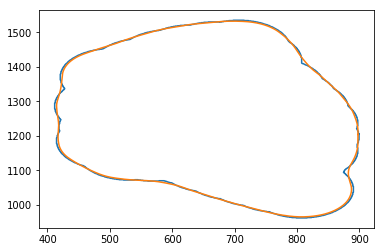

In [10]:
contour = blob_list[4]['contour']
avg_contour = smooth_contour_moving_average(contour)
plt.plot(contour[:,0],contour[:,1])
plt.plot(avg_contour[:,0],avg_contour[:,1])
plt.show()

### How much is covered by orange?
I think this is easiest from the segmented objects rather than the contours. This could also be done using the area property from regionprops

total orange pixels: 244357
percent orange pixels: 6.108925


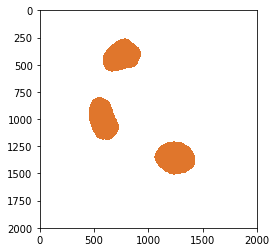

In [11]:
print('total orange pixels: {}'.format(np.sum(label_image == 2)))
print('percent orange pixels: {}'.format(100*(np.sum(label_image == 2)/label_image.size)))
masked_image = np.full_like(im,255)
masked_image[label_image == 2] = im[label_image == 2]
plt.imshow(masked_image)
plt.show()